In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import open_clip
from torchvision import datasets, transforms
import torch
from PIL import Image
import open_clip
from tqdm import tqdm
from torch.utils.data import DataLoader
import numpy as np
from sklearn import calibration
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch.nn as nn
import torch.optim as optim
from sklearn.tree import DecisionTreeRegressor as DT
from sklearn.isotonic import IsotonicRegression as IR
from scipy.stats import norm
from tqdm import tqdm
import pandas as pd

/home/ubuntu/anaconda3/envs/content_understanding/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from util import get_preds, calc_bins, get_metrics, T_scaling, find_temp_scale, get_test_set, get_openai_prompts, get_val_set, find_temp_scale_with_q, get_text_probs, sample_quantile, sample_quantile_unpredicted, get_image_features, get_preds_from_img_features, run_modified_uts

In [4]:
device = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')
batch_size = 128

In [186]:
model_name = 'ViT-B-16'#'ViT-L-14'#'ViT-B-32-quickgelu'
dataset_name = 'CIFAR10'
pretrained_dset = 'laion400m_e31'
num_classes = 10

model, _, preprocess = open_clip.create_model_and_transforms(model_name,
    pretrained=pretrained_dset,
    device=device)
tokenizer = open_clip.get_tokenizer(model_name)

In [187]:
cifar_test, _ = get_test_set(dataset_name, preprocess)
classes, templates = get_openai_prompts(dataset_name)
val_dset = get_val_set(dataset_name, classes, preprocess)

Files already downloaded and verified
Files already downloaded and verified


In [172]:
text_template = templates[1]
text_probs = get_text_probs(
        model=model,
        tokenizer=tokenizer,
        dset=val_dset,
        text_template=text_template,
        batch_size=batch_size,
        device=device
    )

In [6]:
def run_uts(dset, image_features, z_score, text_template):

    text = tokenizer([text_template.replace('{}',x) for x in cifar_test.classes])
    with torch.no_grad(), torch.cuda.amp.autocast():
        text_features = model.encode_text(text.to(device))
        text_features /= text_features.norm(dim=-1, keepdim=True)

    text_probs = (100.0 * image_features @ text_features.T)

    ## Get threshold
    text_probs_numpy = text_probs.softmax(dim=-1).cpu().numpy()

    ## Setup LBGFS
    temperature = nn.Parameter((torch.ones(1)).to(device))
    args = {'temperature': temperature}
    criterion = nn.CrossEntropyLoss()

    # Removing strong_wolfe line search results in jump after 50 epochs
    optimizer = optim.LBFGS([temperature], lr=0.001, max_iter=1000, line_search_fn='strong_wolfe')

    logits_list = []
    labels_list = []

    predicted_label = text_probs_numpy.argmax(axis=1)

    added = np.zeros(len(text_probs_numpy[0]))
    for k in range(len(text_probs_numpy[0])):
        # set where predicted_label is not k
        logits_u = text_probs_numpy[predicted_label != k,:]

        mean_softmax_yk = logits_u[:,k].mean()
        std_softmax_yk = logits_u[:,k].std()

        thresh = mean_softmax_yk + z_score * std_softmax_yk
        for j in np.where(text_probs_numpy[:,k] >= thresh)[0]:
            added[k] += 1
            logits_list.append(text_probs[j].unsqueeze(0))
            labels_list.append(k)

    logits_list = torch.cat(logits_list).to(device) # [len(dset), 100]
    labels_list = torch.FloatTensor(labels_list).to(device).long()

    temps = []
    losses = []
    def _eval():
        loss = criterion(T_scaling(logits_list, args), labels_list)
        loss.backward()
        temps.append(temperature.item())
        losses.append(loss)
        return loss

    optimizer.step(_eval)
    return temperature.item()

In [269]:
models_to_consider = [
    ('ViT-B-16' , 'laion2b_s34b_b88k'),
    ('ViT-L-14' , 'laion2b_s32b_b82k'),
    ('ViT-B-32' , 'laion2b_s34b_b79k'),

    ('ViT-B-16' , 'openai'),
    ('ViT-L-14' , 'openai'),
    ('ViT-B-32' , 'openai'),

    ('ViT-B-16' , 'laion400m_e31'),
    ('ViT-L-14' , 'laion400m_e31'),
    ('ViT-B-32' , 'laion400m_e31'),
]
from collections import defaultdict

uts_eces_perdataset = {
    'CIFAR10' : defaultdict(list),
    'CIFAR100' : defaultdict(list)
}
for dataset_name in ['CIFAR10', 'CIFAR100']:
    for model_name, pretrained_dset in tqdm(models_to_consider):
        model, _, preprocess = open_clip.create_model_and_transforms(model_name,
            pretrained=pretrained_dset,
            device=device)
        tokenizer = open_clip.get_tokenizer(model_name)

        cifar_test, num_classes = get_test_set(dataset_name, preprocess)
        classes, templates = get_openai_prompts(dataset_name)
        #val_dset = get_val_set(dataset_name, classes, preprocess)

        all_test_img_features, actual = get_image_features(
            model,  cifar_test,  batch_size=128, device=device
        )
        
        for z in (np.arange(0.5, 5.5, 0.05)):
            for text_template in templates[1:]:
                uts_temp = run_modified_uts(all_test_img_features, z, text_template, model, tokenizer, cifar_test, device)
                #predictions, actual, probs = get_preds(model, tokenizer, cifar_test, text_template=text_template, temp_scaling=uts_temp, device=device)
                predictions, probs = get_preds_from_img_features(
                    model, tokenizer, cifar_test, all_test_img_features, text_template=text_template, temp_scaling=uts_temp, device = device
                )
                utc_ece,_, utc_acc = get_metrics(predictions, actual, probs)
                uts_eces_perdataset[dataset_name][model_name + ';' + pretrained_dset].append(utc_ece)

  0%|          | 0/9 [00:00<?, ?it/s]

Files already downloaded and verified


 11%|█         | 1/9 [15:49<2:06:36, 949.58s/it]

Files already downloaded and verified


 22%|██▏       | 2/9 [32:53<1:55:54, 993.50s/it]

Files already downloaded and verified


 33%|███▎      | 3/9 [48:32<1:36:50, 968.37s/it]

Files already downloaded and verified


 44%|████▍     | 4/9 [1:00:32<1:12:31, 870.24s/it]

Files already downloaded and verified


 56%|█████▌    | 5/9 [1:13:12<55:22, 830.55s/it]  

Files already downloaded and verified


 67%|██████▋   | 6/9 [1:25:10<39:36, 792.20s/it]

Files already downloaded and verified


 78%|███████▊  | 7/9 [1:41:45<28:37, 858.59s/it]

Files already downloaded and verified


 89%|████████▉ | 8/9 [2:00:41<15:46, 946.95s/it]

Files already downloaded and verified


  0%|          | 0/9 [00:00<?, ?it/s]

Files already downloaded and verified


 11%|█         | 1/9 [22:07<2:56:57, 1327.14s/it]

Files already downloaded and verified


 22%|██▏       | 2/9 [45:15<2:39:01, 1363.02s/it]

Files already downloaded and verified


 33%|███▎      | 3/9 [1:07:18<2:14:28, 1344.79s/it]

Files already downloaded and verified


 44%|████▍     | 4/9 [1:30:02<1:52:42, 1352.51s/it]

Files already downloaded and verified


 56%|█████▌    | 5/9 [1:54:05<1:32:20, 1385.03s/it]

Files already downloaded and verified


 67%|██████▋   | 6/9 [2:17:09<1:09:14, 1384.70s/it]

Files already downloaded and verified


 78%|███████▊  | 7/9 [2:39:36<45:44, 1372.35s/it]  

Files already downloaded and verified


 89%|████████▉ | 8/9 [3:03:09<23:05, 1385.32s/it]

Files already downloaded and verified


100%|██████████| 9/9 [3:25:59<00:00, 1373.29s/it]


In [11]:
model_name = 'ViT-B-16'#'ViT-B-32-quickgelu'
dataset_name = 'CIFAR10'

model, _, preprocess = open_clip.create_model_and_transforms(model_name,
    pretrained='laion400m_e31',
    device=device)
tokenizer = open_clip.get_tokenizer(model_name)

cifar_test, _ = get_test_set(dataset_name, preprocess)
classes, templates = get_openai_prompts(dataset_name)
val_dset = get_val_set(dataset_name, classes, preprocess)
    
all_test_img_features, actual = get_image_features(
        model,  cifar_test,  batch_size=128, device=device
    )
text_template = templates[0]
uts_temp = run_uts(all_test_img_features,1.0, text_template)


#predictions, actual, probs = get_preds(model, tokenizer, cifar_test, text_template=text_template, temp_scaling=uts_temp, device=device)
predictions, probs = get_preds_from_img_features(
    model, tokenizer, cifar_test, all_test_img_features, text_template=text_template, temp_scaling=uts_temp, device = device
)
get_metrics(predictions, actual, probs)

Files already downloaded and verified
Files already downloaded and verified


(0.00463585728704927, 0.18949735164642334, 0.9175)

In [226]:
dataset_name = 'CIFAR10'
models_to_consider = [
    ('ViT-B-16' , 'laion2b_s34b_b88k'),
    ('ViT-L-14' , 'laion2b_s32b_b82k'),
    ('ViT-B-32' , 'laion2b_s34b_b79k'),

    ('ViT-B-16' , 'openai'),
    ('ViT-L-14' , 'openai'),
    ('ViT-B-32' , 'openai'),

    ('ViT-B-16' , 'laion400m_e31'),
    ('ViT-L-14' , 'laion400m_e31'),
    ('ViT-B-32' , 'laion400m_e31'),
]
num_classes = 10

from collections import defaultdict
uts_eces = defaultdict(list)
for model_name, pretrained_dset in tqdm(models_to_consider):
    model, _, preprocess = open_clip.create_model_and_transforms(model_name,
        pretrained=pretrained_dset,
        device=device)
    tokenizer = open_clip.get_tokenizer(model_name)

    cifar_test, _ = get_test_set(dataset_name, preprocess)
    classes, templates = get_openai_prompts(dataset_name)
    val_dset = get_val_set(dataset_name, classes, preprocess)

    all_test_img_features, actual = get_image_features(
        model,  cifar_test,  batch_size=128, device=device
    )

    
    for z in (np.arange(0.5, 5.5, 0.05)):
        uts_temp = run_uts(all_test_img_features,z)
        for text_template in templates[1:]:
            #predictions, actual, probs = get_preds(model, tokenizer, cifar_test, text_template=text_template, temp_scaling=uts_temp, device=device)
            predictions, probs = get_preds_from_img_features(
                model, tokenizer, cifar_test, all_test_img_features, text_template=text_template, temp_scaling=uts_temp, device = device
            )
            utc_ece,_, utc_acc = get_metrics(predictions, actual, probs)
            uts_eces[model_name + ';' + pretrained_dset].append(utc_ece)

  0%|          | 0/9 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified


 11%|█         | 1/9 [01:14<09:58, 74.84s/it]

Files already downloaded and verified
Files already downloaded and verified


 22%|██▏       | 2/9 [03:15<11:50, 101.55s/it]

Files already downloaded and verified
Files already downloaded and verified


 33%|███▎      | 3/9 [04:21<08:34, 85.69s/it] 

Files already downloaded and verified
Files already downloaded and verified


 44%|████▍     | 4/9 [05:25<06:24, 76.93s/it]

Files already downloaded and verified
Files already downloaded and verified


 56%|█████▌    | 5/9 [07:11<05:50, 87.52s/it]

Files already downloaded and verified
Files already downloaded and verified


 67%|██████▋   | 6/9 [08:04<03:47, 75.67s/it]

Files already downloaded and verified
Files already downloaded and verified


 78%|███████▊  | 7/9 [09:21<02:32, 76.30s/it]

Files already downloaded and verified
Files already downloaded and verified


 89%|████████▉ | 8/9 [11:32<01:33, 93.46s/it]

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 9/9 [12:34<00:00, 83.79s/it]


Text(0.5, 1.0, 'CIFAR10')

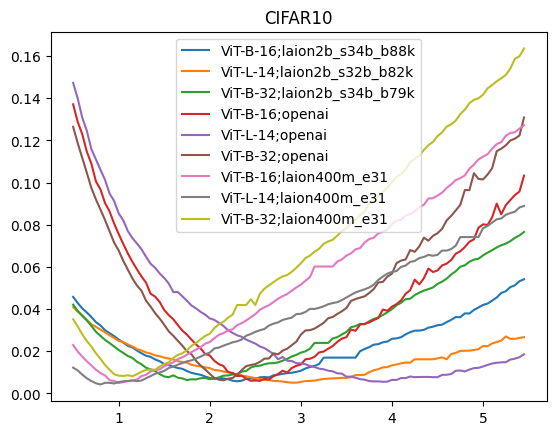

In [228]:
for model_legend,  uts_ece in uts_eces.items():
    plt.plot(np.arange(0.5, 5.5, 0.05), uts_ece, label=model_legend)
plt.legend()
plt.title(f"{dataset_name}")

In [267]:
for model_legend,  uts_ece_cifar100 in sorted(uts_eces_cifar100.items()):
    min_val = np.min(np.array(uts_eces[model_legend]))
    min_temp = np.arange(0.5, 5.5, 0.05)[np.argmin(np.array(uts_eces[model_legend]))]
    print(model_legend)
    print(min_val)
    print(min_temp)

ViT-B-16;laion2b_s34b_b88k
0.005727258267153044
2.3000000000000016
ViT-B-16;laion400m_e31
0.004923669104435567
1.0000000000000004
ViT-B-16;openai
0.00593995287996147
2.5500000000000016
ViT-B-32;laion2b_s34b_b79k
0.006343258885189687
1.750000000000001
ViT-B-32;laion400m_e31
0.008147340560151893
1.1500000000000006
ViT-B-32;openai
0.0062041514857799586
2.1500000000000012
ViT-L-14;laion2b_s32b_b82k
0.00507449877865054
2.900000000000002
ViT-L-14;laion400m_e31
0.0042263555803326944
0.8000000000000003
ViT-L-14;openai
0.005494707163515787
3.900000000000003


In [251]:
uts_eces_cifar100['ViT-L-14;laion400m_e31'][51]

0.09351385622039776

0.8500000000000003

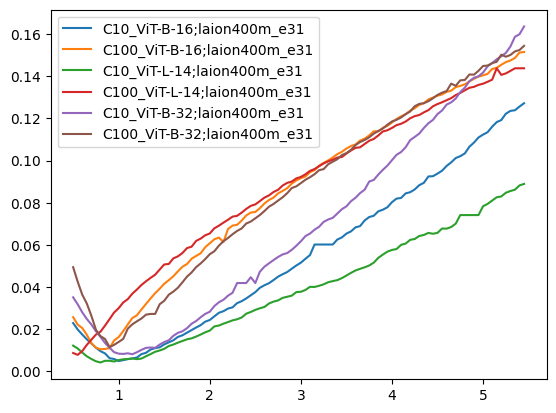

In [259]:
to_consider = []
for model_legend,  uts_ece_cifar100 in uts_eces_cifar100.items():
    if 'laion400m_e31' in model_legend:
        plt.plot(np.arange(0.5, 5.5, 0.05), uts_eces[model_legend], label=f"C10_{model_legend}")
        plt.plot(np.arange(0.5, 5.5, 0.05), uts_eces_cifar100[model_legend], label=f"C100_{model_legend}")
        to_consider.append(np.argmin(uts_eces[model_legend]))
        to_consider.append(np.argmin(uts_eces_cifar100[model_legend]))
plt.legend()
np.arange(0.5, 5.5, 0.05)[int(np.mean(np.array(to_consider)))]

Text(0.5, 1.0, 'CIFAR100')

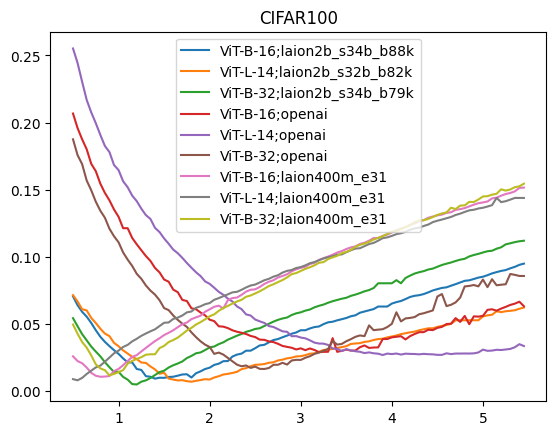

In [230]:
for model_legend,  uts_ece_cifar100 in uts_eces_cifar100.items():
    plt.plot(np.arange(0.5, 5.5, 0.05), uts_ece_cifar100, label=model_legend)
plt.legend()
plt.title(f"{dataset_name}")

Text(0.5, 1.0, 'CIFAR10 laion2b_s34b_b79k ')

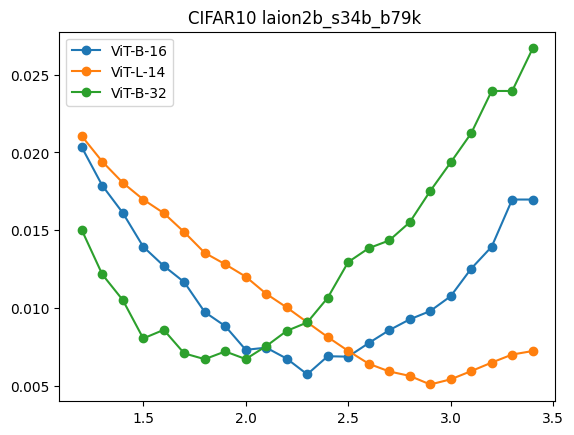

In [222]:
for model_name, uts_ece in uts_eces.items():
    plt.plot(np.arange(0.5, 5.5, 0.1)[7:30], uts_ece[7:30], marker='o', label=model_name)
plt.legend()
plt.title(f"{dataset_name} {pretrained_dset}")

In [189]:
text_template = templates[1]
utc_eces = []
all_test_img_features, actual = get_image_features(
    model,  cifar_test,  batch_size=128, device=device
)
for z in tqdm(np.arange(0.5, 1.5, 0.1)):

    uts_temp = run_uts(all_test_img_features,z)
    #predictions, actual, probs = get_preds(model, tokenizer, cifar_test, text_template=text_template, temp_scaling=uts_temp, device=device)
    predictions, probs = get_preds_from_img_features(
        model, tokenizer, cifar_test, all_test_img_features, text_template=text_template, temp_scaling=uts_temp, device = device
    )
    utc_ece,_, utc_acc = get_metrics(predictions, actual, probs)
    utc_eces.append(utc_ece)

100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


100%|██████████| 50/50 [00:28<00:00,  1.76it/s]


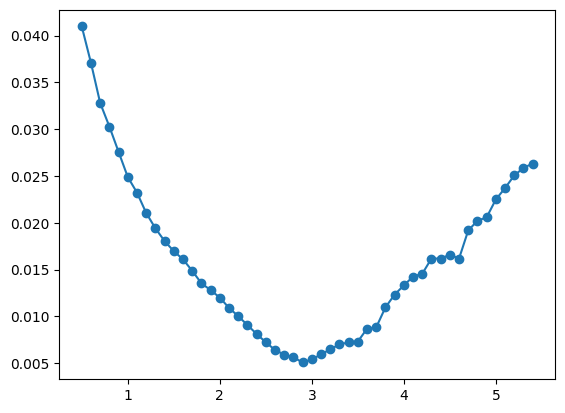

In [193]:
utc_eces = []
for z in tqdm(np.arange(0.5, 5.5, 0.1)):

    uts_temp = run_uts(all_test_img_features,z)
    #predictions, actual, probs = get_preds(model, tokenizer, cifar_test, text_template=text_template, temp_scaling=uts_temp, device=device)
    predictions, probs = get_preds_from_img_features(
        model, tokenizer, cifar_test, all_test_img_features, text_template=text_template, temp_scaling=uts_temp, device = device
    )
    utc_ece,_, utc_acc = get_metrics(predictions, actual, probs)
    utc_eces.append(utc_ece)
plt.plot(np.arange(0.5, 5.5, 0.1), utc_eces, marker='o')

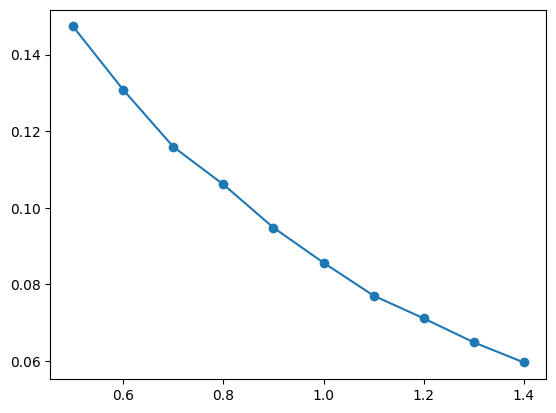

In [184]:
plt.plot(np.arange(0.5, 1.5, 0.1), utc_eces, marker='o')

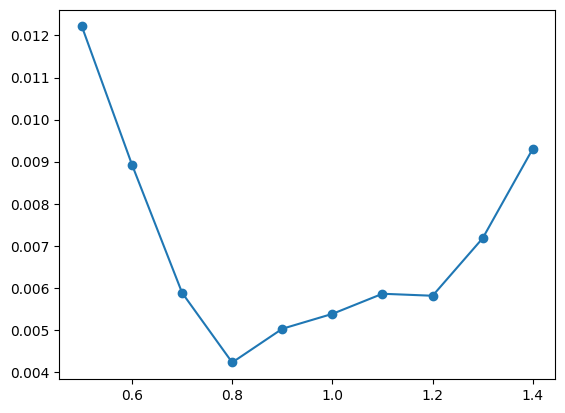

In [180]:
plt.plot(np.arange(0.5, 1.5, 0.1), utc_eces, marker='o')
#for n, u in zip(np.arange(0.5, 1.5, 0.1), utc_eces):
#    print(n,u)

(array([9.083e+03, 2.300e+02, 8.900e+01, 6.600e+01, 4.000e+01, 3.100e+01,
        3.200e+01, 1.100e+01, 2.400e+01, 1.600e+01, 1.300e+01, 7.000e+00,
        1.100e+01, 1.000e+01, 1.000e+01, 5.000e+00, 9.000e+00, 8.000e+00,
        7.000e+00, 2.000e+00, 6.000e+00, 8.000e+00, 9.000e+00, 6.000e+00,
        8.000e+00, 2.000e+00, 4.000e+00, 9.000e+00, 5.000e+00, 1.000e+00,
        5.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 3.000e+00, 5.000e+00,
        2.000e+00, 2.000e+00, 4.000e+00, 1.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 3.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 3.000e+00, 1.000e+00, 1.000e+00,
        3.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 1.000e+00,
        2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 3.000e+0

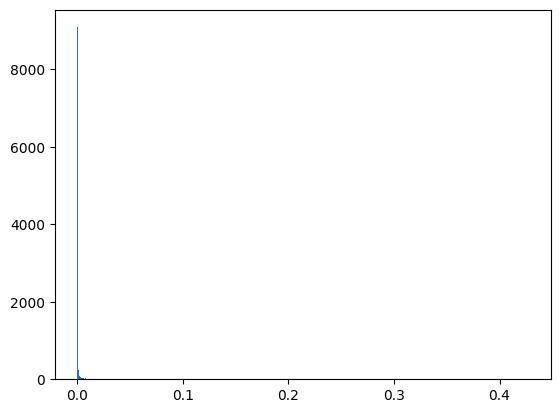

In [69]:
plt.hist(text_probs_numpy[np.where(text_probs_numpy.argmax(axis=1) != 3)[0],3], bins=500)
#plt.ylim([0,500])

In [147]:
added

array([2092., 2521., 3333., 2223., 1893., 2511., 1275., 2421., 1627.,
       1310.])

In [145]:
predictions, actual, probs = get_preds(model, tokenizer, cifar_test, text_template=text_template, temp_scaling=temperature.item(), device=device)
utc_ece,_, utc_acc = get_metrics(predictions, actual, probs)
utc_ece, utc_acc

(0.01793091900050642, 0.7037)

In [80]:
predictions, actual, probs = get_preds(model, tokenizer, cifar_test, text_template=text_template, temp_scaling=temperature.item(), device=device)
get_metrics(predictions, actual, probs)

(0.0052937988311052625, 0.1899001955986023, 0.9175)

In [81]:
temperature.item()

1.5175397396087646

In [84]:
temps_learned, eces_learned = sample_quantile(0.85, 0.90, 0.005, text_probs , device, model, tokenizer, cifar_test, text_template)

100%|██████████| 11/11 [03:06<00:00, 16.92s/it]


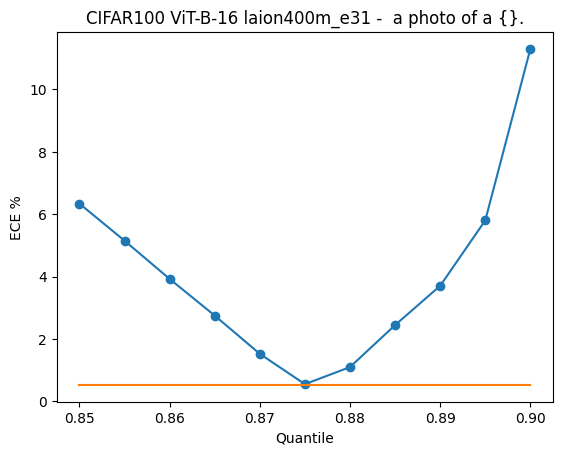

In [85]:
plt.plot(np.arange(0.85, 0.90, 0.005), np.array(eces_learned)*100, marker='o')
plt.title(f"CIFAR100 {model_name} laion400m_e31 -  {text_template}")
plt.ylabel('ECE %')
plt.xlabel('Quantile')
plt.plot(np.arange(0.85, 0.90, 0.005), np.array([0.0052937988311052625]*len(np.arange(0.85, 0.90, 0.005))) * 100, '-')

In [94]:
temps_learned, eces_learned = sample_quantile_unpredicted(0.5, 0.999, 0.05, text_probs , device, model, tokenizer, cifar_test, text_template)

100%|██████████| 10/10 [02:53<00:00, 17.38s/it]


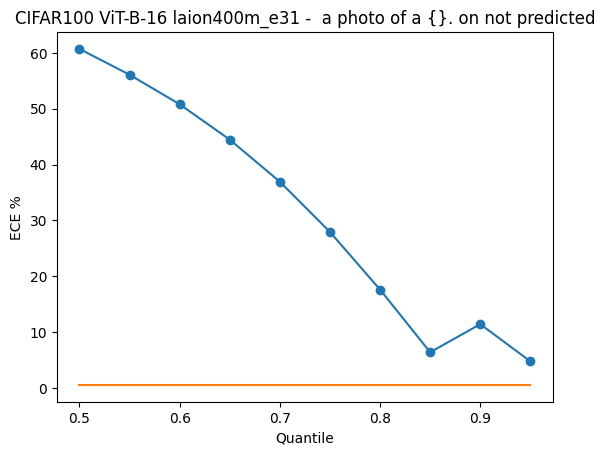

In [96]:
xaxis = np.arange(0.5, 0.999, 0.05)
plt.plot(xaxis, np.array(eces_learned)*100, marker='o')
plt.title(f"CIFAR10 {model_name} laion400m_e31 -  {text_template} on not predicted")
plt.ylabel('ECE %')
plt.xlabel('Quantile')
plt.plot(xaxis, np.array([0.0052937988311052625]*len(xaxis)) * 100, '-')

100%|██████████| 50/50 [00:30<00:00,  1.66it/s]


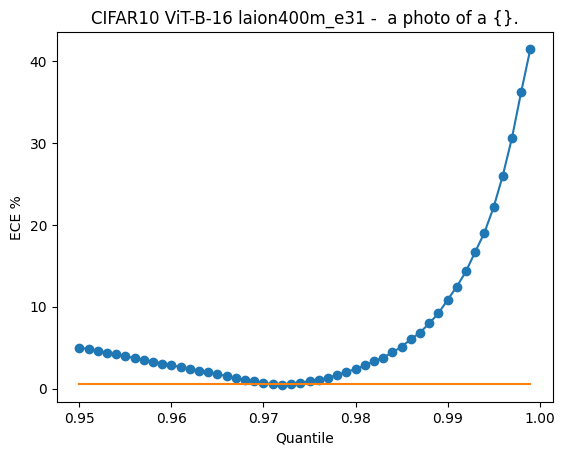

In [130]:
temps_learned, eces_learned = sample_quantile_unpredicted(0.95, 0.999, 0.001, text_probs , device, model, tokenizer, cifar_test, text_template)
xaxis = np.arange(0.95, 0.999, 0.001)
plt.plot(xaxis, np.array(eces_learned)*100, marker='o')
plt.title(f"CIFAR10 {model_name} laion400m_e31 -  {text_template}")
plt.ylabel('ECE %')
plt.xlabel('Quantile')
plt.plot(xaxis, np.array([0.0052937988311052625]*len(xaxis)) * 100, '-')

In [119]:
uts_cifar10 ,np.min(eces_learned)

(0.005293798831105262, 0.0044098978238666636)

100%|██████████| 50/50 [00:30<00:00,  1.66it/s]


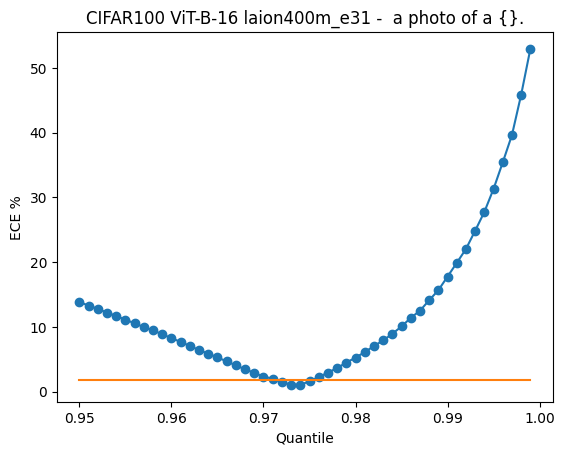

In [123]:
temps_learned, eces_learned = sample_quantile_unpredicted(0.95, 0.999, 0.001, text_probs , device, model, tokenizer, cifar_test, text_template)
xaxis = np.arange(0.95, 0.999, 0.001)
plt.plot(xaxis, np.array(eces_learned)*100, marker='o')
plt.title(f"CIFAR100 {model_name} laion400m_e31 -  {text_template}")
plt.ylabel('ECE %')
plt.xlabel('Quantile')
plt.plot(xaxis, np.array([0.017992428556829688]*len(xaxis)) * 100, '-')

In [125]:
uts_cifar100 ,np.min(eces_learned)

(0.017992428556829688, 0.010297298431396472)

In [127]:
xaxis[np.where(np.array(eces_learned) < uts_cifar100)[0]]

array([0.972, 0.973, 0.974, 0.975])

In [131]:
xaxis[np.where(np.array(eces_learned) < uts_cifar10)[0]]

array([0.972])

100%|██████████| 50/50 [00:18<00:00,  2.67it/s]


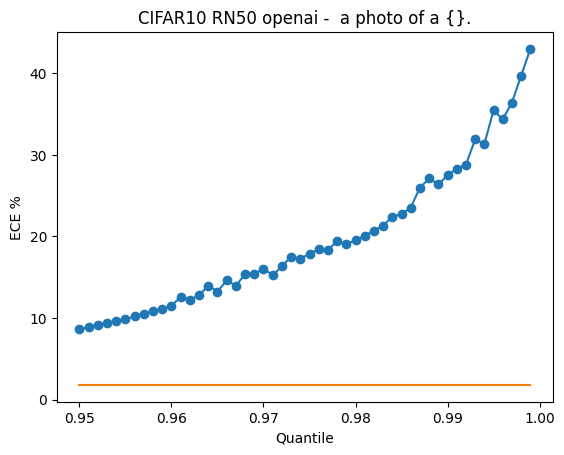

In [146]:
temps_learned, eces_learned = sample_quantile_unpredicted(0.95, 0.999, 0.001, text_probs , device, model, tokenizer, cifar_test, text_template)
xaxis = np.arange(0.95, 0.999, 0.001)
plt.plot(xaxis, np.array(eces_learned)*100, marker='o')
plt.title(f"CIFAR10 {model_name} {pretrained_dset} -  {text_template}")
plt.ylabel('ECE %')
plt.xlabel('Quantile')
plt.plot(xaxis, np.array([utc_ece]*len(xaxis)) * 100, '-')

In [139]:
xaxis[np.where(np.array(eces_learned) <= utc_ece)[0]]

array([], dtype=float64)